In [249]:
import pandas as pd
import numpy as np
import dataframe_image as dfi

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

# Exclude events with null attendance
df = df[df['event_attendance'].notnull()]

# Extract year and filter for AEW/WWE
df['year'] = df['calendar_date'].dt.year
promos = ['AEW', 'WWE']
df = df[df['promotion'].isin(promos)]

# Create a unique event identifier
df['event_id'] = df['calendar_date'].astype(str) + '_' + df['event_name']

# Group by year and promotion, counting unique events
summary = df.groupby(['year', 'promotion']).agg(
    events=('event_id', 'nunique'),
    avg_attendance=('event_attendance', 'mean')
).reset_index()

# Pivot for AEW/WWE columns
pivot_events = summary.pivot(index='year', columns='promotion', values='events')
pivot_avg = summary.pivot(index='year', columns='promotion', values='avg_attendance')

# Calculate percent changes
events_pct_change = (pivot_events.pct_change() * 100).round(0).astype('Int64')
avg_pct_change = (pivot_avg.pct_change() * 100).round(0).astype('Int64')

# Combine into DataFrame, round to integer
result = pd.DataFrame({
    'aew events': pivot_events['AEW'].astype('Int64'),
    'aew event % change': events_pct_change['AEW'],
    'wwe events': pivot_events['WWE'].astype('Int64'),
    'wwe event % change': events_pct_change['WWE'],
    'aew avg attendance': pivot_avg['AEW'].round(0).astype('Int64'),
    'aew avg attendance % change': avg_pct_change['AEW'],
    'wwe avg attendance': pivot_avg['WWE'].round(0).astype('Int64'),
    'wwe avg attendance % change': avg_pct_change['WWE'],
}).reset_index()

# Build totals row with correct dtypes
totals = {
    'year': 'Total',
    'aew events': result['aew events'].sum(),
    'aew event % change': pd.NA,
    'wwe events': result['wwe events'].sum(),
    'wwe event % change': pd.NA,
    'aew avg attendance': int(df[df['promotion']=='AEW'].drop_duplicates('event_id')['event_attendance'].mean().round(0)),
    'aew avg attendance % change': pd.NA,
    'wwe avg attendance': int(df[df['promotion']=='WWE'].drop_duplicates('event_id')['event_attendance'].mean().round(0)),
    'wwe avg attendance % change': pd.NA,
}
# Create totals_df with same columns and dtypes as result
totals_df = pd.DataFrame([totals], columns=result.columns)
for col in result.columns:
    if col != 'year':
        totals_df[col] = totals_df[col].astype(result[col].dtype)

result_display = pd.concat([totals_df, result], ignore_index=True)

# Ensure year is int except for 'Total'
def fix_year(val):
    try:
        return int(val)
    except:
        return val
result_display['year'] = result_display['year'].apply(fix_year)

# Styling functions
def highlight_total_row(row):
    return ['background-color: #ffe599; font-weight: bold' if row['year'] == 'Total' else '' for _ in row]

def highlight_pct(val):
    if pd.isnull(val):
        return ''
    if val > 0:
        return 'color: green'
    elif val < 0:
        return 'color: red'
    else:
        return ''

# Add % sign to percent columns
def pct_fmt(val):
    if pd.isnull(val) or val == '':
        return ''
    return f"{int(val):,}%"

percent_cols = [col for col in result_display.columns if 'change' in col]
num_cols = [col for col in result_display.columns if col not in ['year'] + percent_cols]

styler = (
    result_display.style
    .apply(highlight_total_row, axis=1)
    .map(highlight_pct, subset=percent_cols)
    .format(na_rep='', thousands=',', precision=0, subset=num_cols)
    .format(pct_fmt, subset=percent_cols)
    .hide(axis="index")  # <-- This removes the index column
)

dfi.export(styler, 'summary_table_by_year_events_attendance.png', table_conversion='matplotlib')
styler


year,aew events,aew event % change,wwe events,wwe event % change,aew avg attendance,aew avg attendance % change,wwe avg attendance,wwe avg attendance % change
Total,474,,449,,"4,654",,"10,128",
2021,46,,73,,"6,120",,"5,376",
2022,82,78%,115,58%,"6,074",-1%,"9,054",68%
2023,141,72%,115,0%,"5,723",-6%,"11,296",25%
2024,158,12%,110,-4%,"3,887",-32%,"12,257",9%
2025,47,-70%,36,-67%,"3,055",-21%,"14,566",19%


In [250]:
import pandas as pd
import numpy as np
import dataframe_image as dfi

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

# Filter: only events with non-null attendance
df = df[df['event_attendance'].notnull()]

# Extract year and filter for AEW/WWE
df['year'] = df['calendar_date'].dt.year
promos = ['AEW', 'WWE']
df = df[df['promotion'].isin(promos)]

# Only keep matches with non-null duration
df = df[df['match_duration_seconds'].notnull()]

# Calculate match duration in minutes (float)
df['match_duration_minutes'] = df['match_duration_seconds'] / 60

# Group by year and promotion
summary = df.groupby(['year', 'promotion']).agg(
    matches=('match_duration_minutes', 'count'),
    avg_duration=('match_duration_minutes', 'mean')
).reset_index()

# Pivot for AEW/WWE columns
pivot_matches = summary.pivot(index='year', columns='promotion', values='matches')
pivot_avg_duration = summary.pivot(index='year', columns='promotion', values='avg_duration')

# Calculate percent changes SEPARATELY for each promotion
aew_matches_pct_change = pivot_matches['AEW'].pct_change().multiply(100).round(0).astype('Int64')
wwe_matches_pct_change = pivot_matches['WWE'].pct_change().multiply(100).round(0).astype('Int64')
aew_duration_pct_change = pivot_avg_duration['AEW'].pct_change().multiply(100).round(0).astype('Int64')
wwe_duration_pct_change = pivot_avg_duration['WWE'].pct_change().multiply(100).round(0).astype('Int64')

# Build result DataFrame, rounding avg durations to 2 decimals (minutes)
result = pd.DataFrame({
    'aew matches': pivot_matches['AEW'].astype('Int64'),
    'aew matches % change': aew_matches_pct_change,
    'wwe matches': pivot_matches['WWE'].astype('Int64'),
    'wwe matches % change': wwe_matches_pct_change,
    'aew avg match duration': pivot_avg_duration['AEW'].round(2),
    'aew match duration % change': aew_duration_pct_change,
    'wwe avg match duration': pivot_avg_duration['WWE'].round(2),
    'wwe match duration % change': wwe_duration_pct_change,
}).reset_index()

# Build totals row with avg match durations rounded to 2 decimals (minutes)
totals = {
    'year': 'Total',
    'aew matches': result['aew matches'].sum(),
    'aew matches % change': pd.NA,
    'wwe matches': result['wwe matches'].sum(),
    'wwe matches % change': pd.NA,
    'aew avg match duration': round(df[df['promotion']=='AEW']['match_duration_minutes'].mean(), 2),
    'aew match duration % change': pd.NA,
    'wwe avg match duration': round(df[df['promotion']=='WWE']['match_duration_minutes'].mean(), 2),
    'wwe match duration % change': pd.NA,
}
totals_df = pd.DataFrame([totals], columns=result.columns)
for col in result.columns:
    if col != 'year':
        totals_df[col] = totals_df[col].astype(result[col].dtype, errors='ignore')

result_display = pd.concat([totals_df, result], ignore_index=True)

# Ensure year is int except for 'Total'
def fix_year(val):
    try:
        return int(val)
    except:
        return val
result_display['year'] = result_display['year'].apply(fix_year)

# Styling
def highlight_total_row(row):
    return ['background-color: #ffe599; font-weight: bold' if row['year'] == 'Total' else '' for _ in row]

def highlight_pct(val):
    if pd.isnull(val):
        return ''
    if val > 0:
        return 'color: green'
    elif val < 0:
        return 'color: red'
    else:
        return ''

def pct_fmt(val):
    if pd.isnull(val) or val == '':
        return ''
    return f"{int(val):,}%"

percent_cols = [col for col in result_display.columns if 'change' in col]
num_cols = [col for col in result_display.columns if col not in ['year'] + percent_cols]

# Identify columns for specific formatting
percent_cols = [col for col in result_display.columns if 'change' in col]
avg_duration_cols = [col for col in result_display.columns if 'avg match duration' in col]
num_cols = [col for col in result_display.columns if col not in ['year'] + percent_cols + avg_duration_cols]

styler = (
    result_display.style
    .apply(highlight_total_row, axis=1)
    .map(highlight_pct, subset=percent_cols)
    .format(na_rep='', thousands=',', precision=0, subset=num_cols)  # whole numbers for counts
    .format("{:.2f}", subset=avg_duration_cols)                      # two decimals for avg durations
    .format(pct_fmt, subset=percent_cols)
    .hide(axis="index")
)

dfi.export(styler, 'summary_table_by_year_matches_duration.png', table_conversion='matplotlib')
styler


year,aew matches,aew matches % change,wwe matches,wwe matches % change,aew avg match duration,aew match duration % change,wwe avg match duration,wwe match duration % change
Total,"2,529",,"2,620",,10.54,,9.93,
2021,218,,481,,10.33,,8.46,
2022,419,92%,715,49%,10.37,0%,9.34,10%
2023,730,74%,637,-11%,10.53,2%,10.21,9%
2024,871,19%,590,-7%,10.58,0%,10.78,6%
2025,291,-67%,197,-67%,10.82,2%,12.21,13%


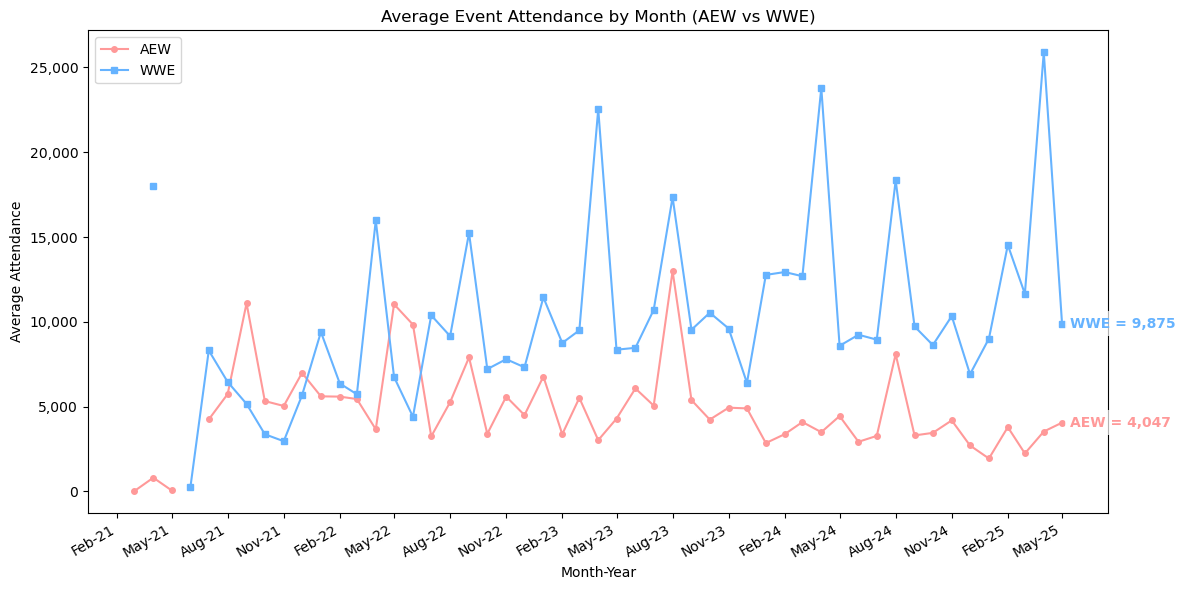

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np

# Load the data
df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

# Prepare data
df['year_month'] = df['calendar_date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby(['promotion', 'year_month'])['event_attendance'].mean().reset_index()
promos = ['AEW', 'WWE']
monthly = monthly[monthly['promotion'].isin(promos)]
pivot = monthly.pivot(index='year_month', columns='promotion', values='event_attendance')

fig, ax = plt.subplots(figsize=(12, 6))

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}
markers = {'AEW': 'o', 'WWE': 's'}

for promo in promos:
    if promo in pivot:
        ax.plot(
            pivot.index,
            pivot[promo],
            label=promo,
            marker=markers.get(promo, 'o'),
            markersize=4,
            color=colors.get(promo, None)
        )
        # Find the last valid index (non-NaN) for this promo
        valid_idx = pivot[promo].last_valid_index()
        if valid_idx is not None and not np.isnan(pivot[promo].loc[valid_idx]):
            last_x = valid_idx
            last_y = pivot[promo].loc[valid_idx]
            label_text = f"{promo} = {int(last_y):,}"
            # Annotate directly at the last data point with a small offset in points
            ax.annotate(
                label_text,
                xy=(last_x, last_y),
                xytext=(6, 0),  # 6 points to the right for clarity, not in data units
                textcoords='offset points',
                color=colors.get(promo, None),
                fontsize=10,
                fontweight='bold',
                va='center',
                ha='left',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                clip_on=False  # Allows label to extend outside axes if needed
            )

# Format x-axis: show every 3rd month, label as mmm-yy
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# Format y-axis with commas
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.set_title('Average Event Attendance by Month (AEW vs WWE)')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Average Attendance')
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
fig.savefig('avg_attendance_by_month.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()


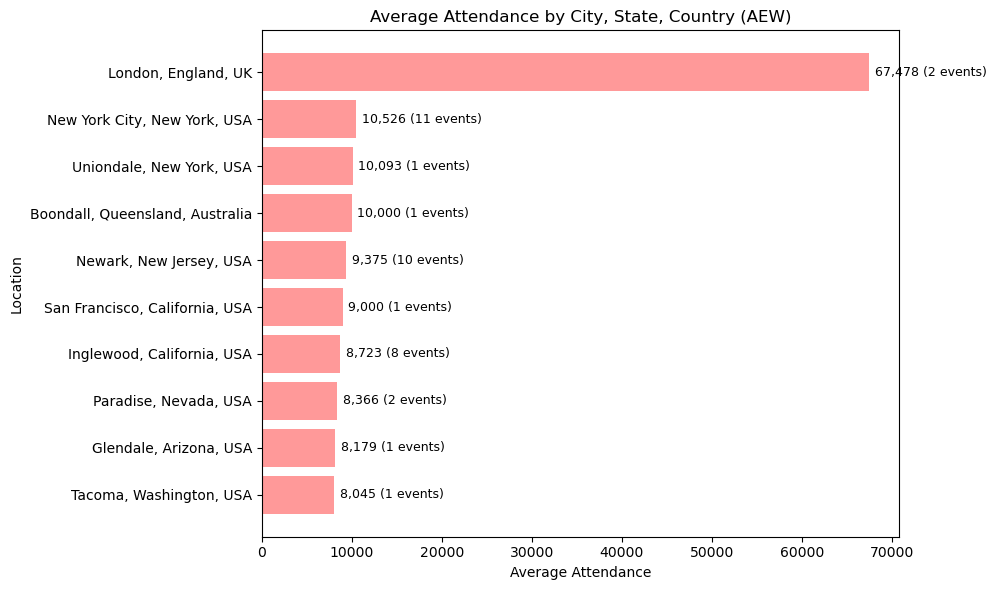

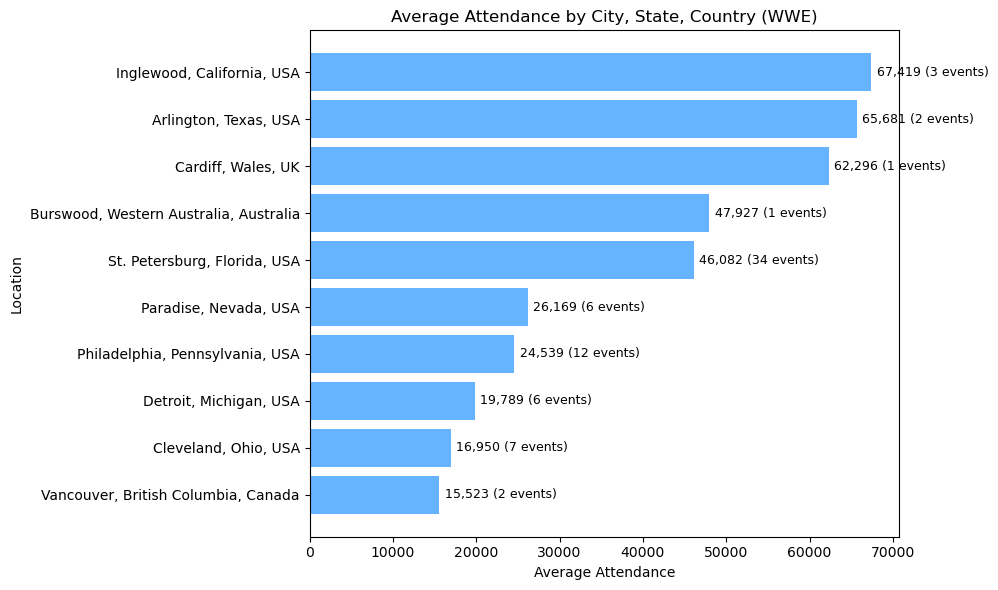

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])
df['location'] = df['event_city'] + ', ' + df['event_state'] + ', ' + df['event_country']

def plot_avg_attendance_by_location(promo, color, filename):
    sub = df[df['promotion'] == promo].copy()
    # Create a unique event identifier for each event
    sub['event_id'] = sub['calendar_date'].astype(str) + '|' + sub['event_name']
    stats = sub.groupby('location').agg(
        mean_attendance=('event_attendance', 'mean'),
        event_count=('event_id', 'nunique')  # Count unique events per location
    )
    stats = stats.dropna()
    stats = stats.sort_values('mean_attendance', ascending=False).head(10)
    stats = stats.iloc[::-1]
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats.index, stats['mean_attendance'], color=color)
    # Label: avg attendance (X events)
    labels = [f"{int(m):,} ({int(c)} events)" for m, c in zip(stats['mean_attendance'], stats['event_count'])]
    ax.bar_label(bars, labels=labels, fontsize=9, padding=4)
    ax.set_title(f'Average Attendance by City, State, Country ({promo})')
    ax.set_xlabel('Average Attendance')
    ax.set_ylabel('Location')
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with unique filename
    plt.show()

# Save both images with unique filenames
plot_avg_attendance_by_location('AEW', colors['AEW'], 'avg_attendance_by_location_AEW.png')
plot_avg_attendance_by_location('WWE', colors['WWE'], 'avg_attendance_by_location_WWE.png')


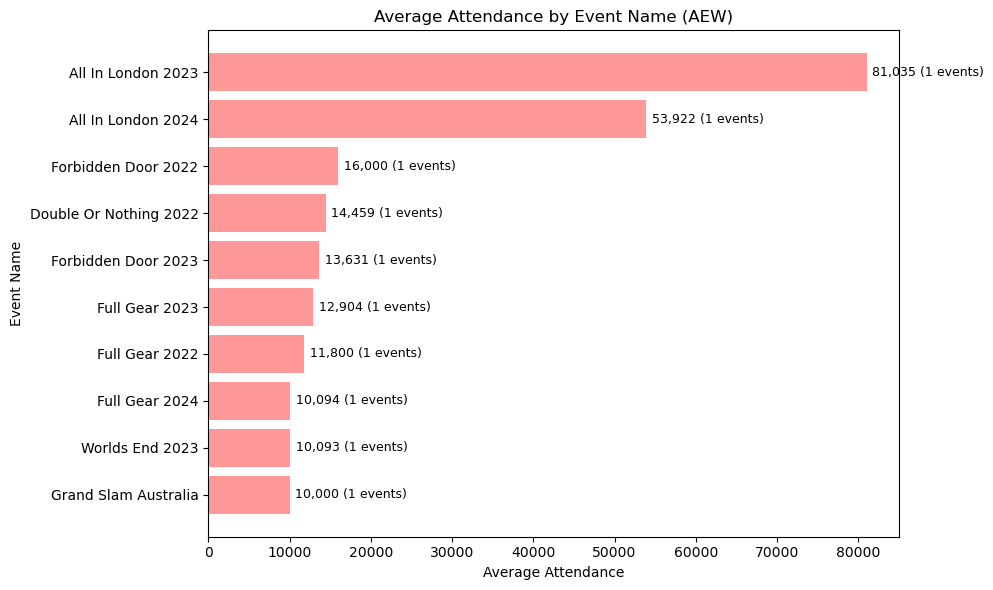

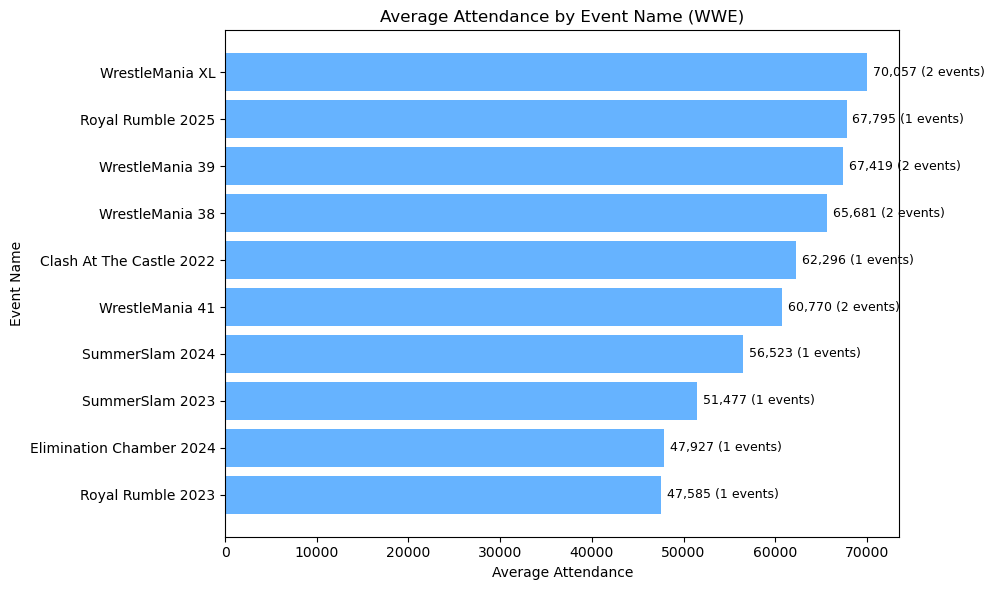

In [236]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

def plot_avg_attendance_by_event_name(promo, color, filename):
    sub = df[df['promotion'] == promo].copy()
    # Create a unique event identifier for each event occurrence
    sub['event_id'] = sub['calendar_date'].astype(str) + '|' + sub['event_name']
    # Count unique event occurrences for each event_name
    stats = sub.groupby('event_name').agg(
        mean_attendance=('event_attendance', 'mean'),
        event_count=('event_id', 'nunique')  # Count unique (date, event_name) pairs
    )
    stats = stats.dropna()
    stats = stats.sort_values('mean_attendance', ascending=False).head(10)
    stats = stats.iloc[::-1]
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats.index, stats['mean_attendance'], color=color)
    # Label: avg attendance (X events)
    labels = [f"{int(m):,} ({int(c)} events)" for m, c in zip(stats['mean_attendance'], stats['event_count'])]
    ax.bar_label(bars, labels=labels, fontsize=9, padding=4)
    ax.set_title(f'Average Attendance by Event Name ({promo})')
    ax.set_xlabel('Average Attendance')
    ax.set_ylabel('Event Name')
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with unique filename
    plt.show()

# Save both images with unique filenames
plot_avg_attendance_by_event_name('AEW', colors['AEW'], 'avg_attendance_by_event_name_AEW.png')
plot_avg_attendance_by_event_name('WWE', colors['WWE'], 'avg_attendance_by_event_name_WWE.png')


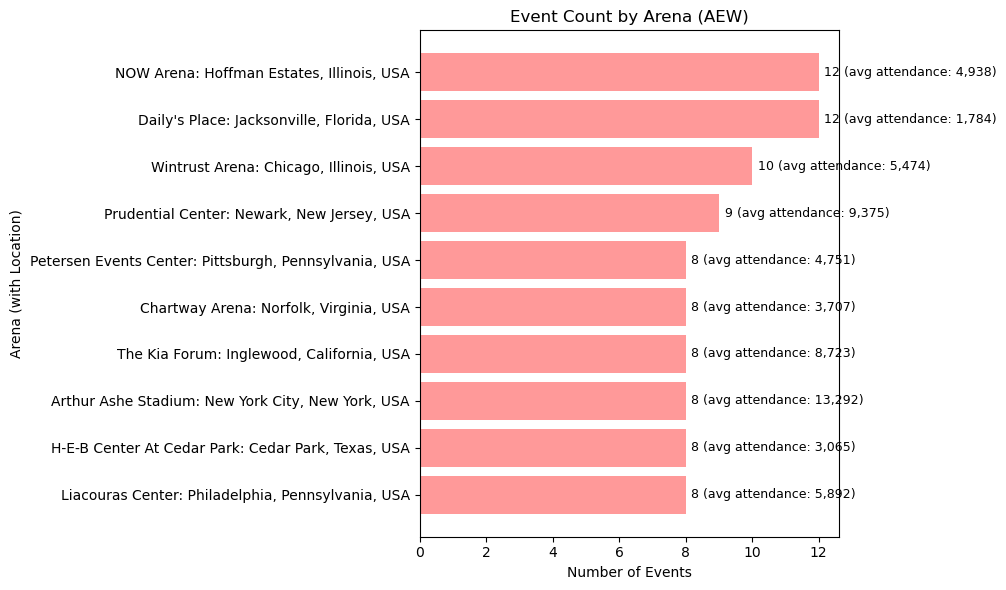

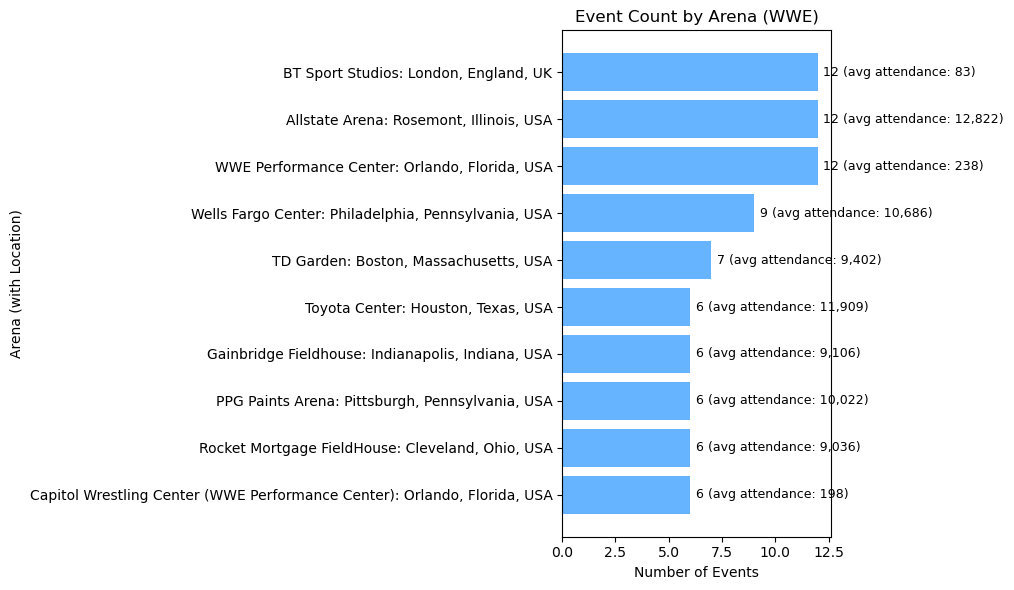

In [239]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

def plot_event_count_by_arena(promo, color, filename):
    sub = df[df['promotion'] == promo].copy()
    sub = sub[sub['event_attendance'].notnull()]
    
    # Create a composite label with arena and location info
    sub['arena_label'] = (
        sub['event_arena_name'].fillna('Unknown') + ': ' +
        sub['event_city'].fillna('Unknown') + ', ' +
        sub['event_state'].fillna('Unknown') + ', ' +
        sub['event_country'].fillna('Unknown')
    )
    
    # Create a unique event identifier for each event (date + name)
    sub['event_id'] = sub['calendar_date'].astype(str) + '|' + sub['event_name']
    
    # Group by the composite label and count unique events
    stats = sub.groupby('arena_label').agg(
        mean_attendance=('event_attendance', 'mean'),
        event_count=('event_id', 'nunique')  # Unique (date + event_name) per arena
    )
    stats = stats.dropna()
    stats = stats.sort_values('event_count', ascending=False).head(10)
    stats = stats.iloc[::-1]  # For horizontal bar order (top to bottom)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats.index, stats['event_count'], color=color)
    # Label: event count (avg attendance)
    labels = [f"{int(c)} (avg attendance: {int(m):,})" for c, m in zip(stats['event_count'], stats['mean_attendance'])]
    ax.bar_label(bars, labels=labels, fontsize=9, padding=4)
    ax.set_title(f'Event Count by Arena ({promo})')
    ax.set_xlabel('Number of Events')
    ax.set_ylabel('Arena (with Location)')
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with unique filename
    plt.show()

plot_event_count_by_arena('AEW', colors['AEW'], 'event_count_by_arena_AEW.png')
plot_event_count_by_arena('WWE', colors['WWE'], 'event_count_by_arena_WWE.png')


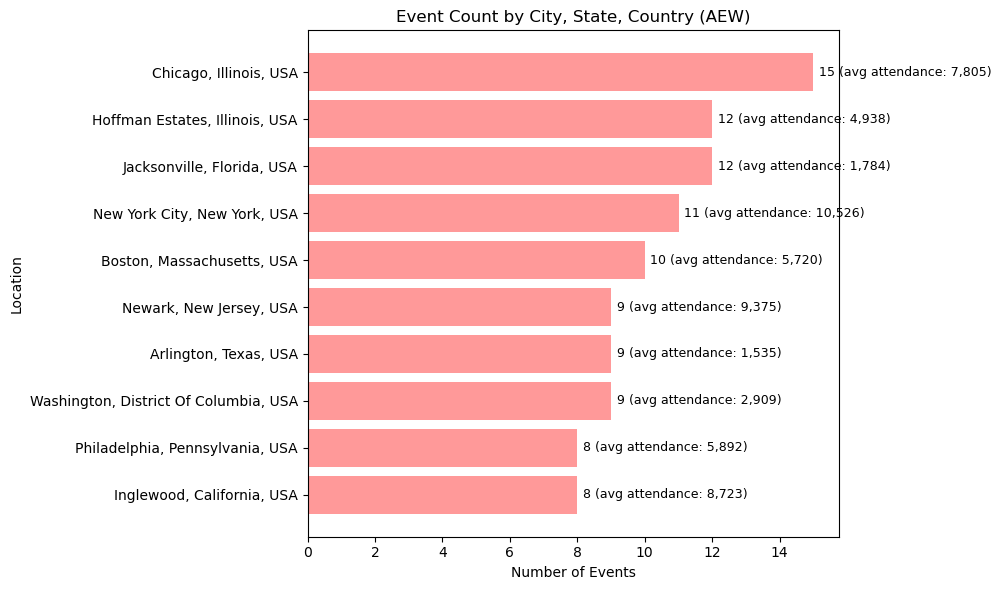

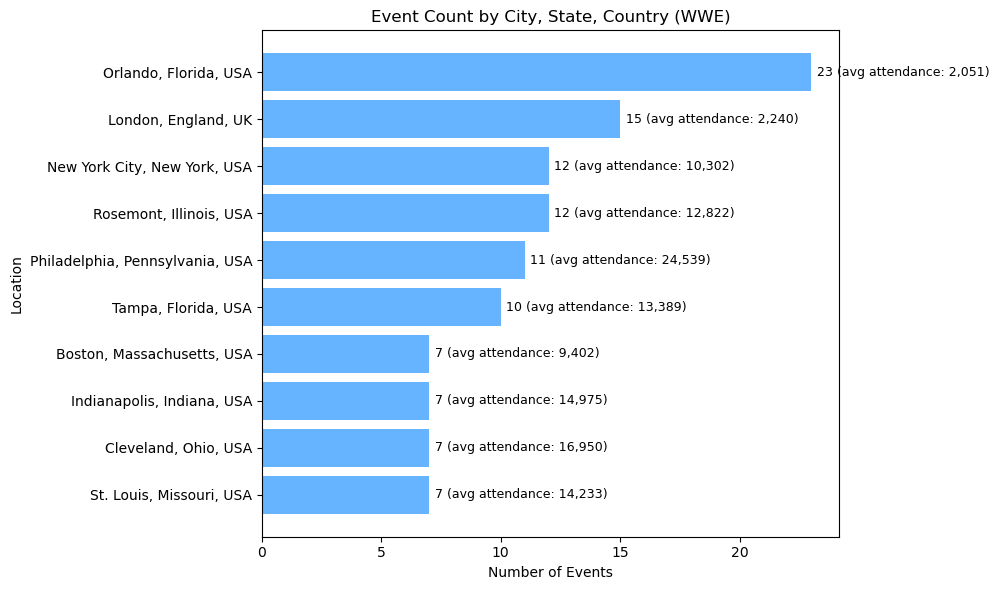

In [240]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])
df['location'] = df['event_city'] + ', ' + df['event_state'] + ', ' + df['event_country']

def plot_event_count_by_location(promo, color, filename):
    sub = df[df['promotion'] == promo].copy()
    # Only include events with non-null attendance
    sub = sub[sub['event_attendance'].notnull()]

    # Create a unique event identifier for each event (date + name)
    sub['event_id'] = sub['calendar_date'].astype(str) + '|' + sub['event_name']

    stats = sub.groupby('location').agg(
        mean_attendance=('event_attendance', 'mean'),
        event_count=('event_id', 'nunique')  # Unique (date + event_name) per location
    )
    stats = stats.dropna()
    stats = stats.sort_values('event_count', ascending=False).head(10)
    stats = stats.iloc[::-1]  # For horizontal bar order (top to bottom)
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats.index, stats['event_count'], color=color)
    # Label: event count (avg attendance)
    labels = [f"{int(c)} (avg attendance: {int(m):,})" for c, m in zip(stats['event_count'], stats['mean_attendance'])]
    ax.bar_label(bars, labels=labels, fontsize=9, padding=4)
    ax.set_title(f'Event Count by City, State, Country ({promo})')
    ax.set_xlabel('Number of Events')
    ax.set_ylabel('Location')
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with unique filename
    plt.show()

plot_event_count_by_location('AEW', colors['AEW'], 'event_count_by_location_AEW.png')
plot_event_count_by_location('WWE', colors['WWE'], 'event_count_by_location_WWE.png')


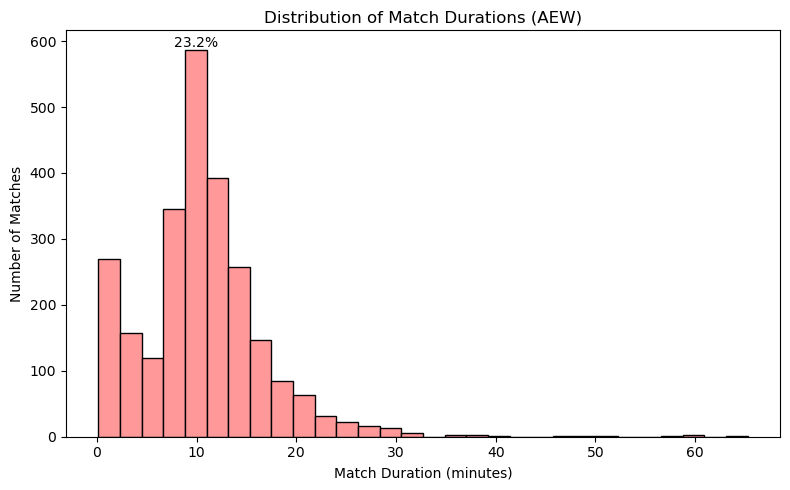

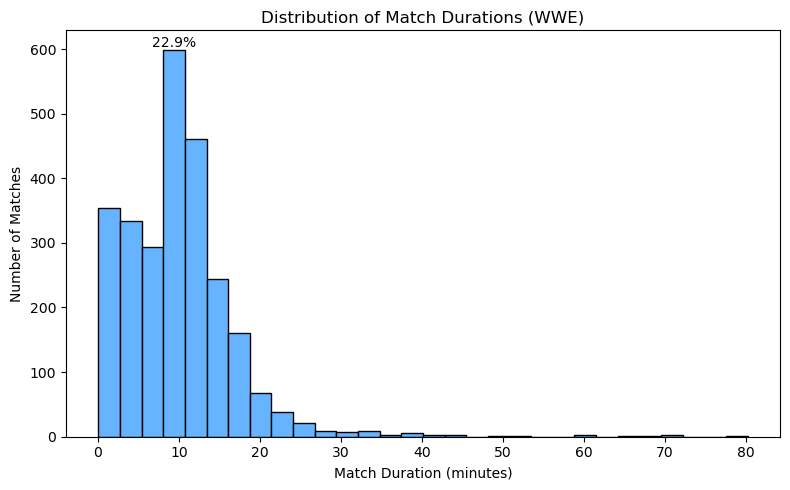

In [252]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

# Only include matches from events with non-null attendance
aew_durations = df[(df['promotion'] == 'AEW') & (df['event_attendance'].notnull())]['match_duration_seconds'].dropna() / 60
wwe_durations = df[(df['promotion'] == 'WWE') & (df['event_attendance'].notnull())]['match_duration_seconds'].dropna() / 60

bins = 30

# AEW Chart
fig, ax = plt.subplots(figsize=(8,5))
counts, bin_edges, _ = ax.hist(aew_durations, bins=bins, color='#ff9999', edgecolor='black')
total = counts.sum()
max_idx = counts.argmax()
percent = 100 * counts[max_idx] / total
center = (bin_edges[max_idx] + bin_edges[max_idx+1]) / 2
ax.text(center, counts[max_idx], f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)
ax.set_xlabel('Match Duration (minutes)')
ax.set_ylabel('Number of Matches')
ax.set_title('Distribution of Match Durations (AEW)')
plt.tight_layout()
fig.savefig('match_duration_distribution_AEW.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

# WWE Chart
fig, ax = plt.subplots(figsize=(8,5))
counts, bin_edges, _ = ax.hist(wwe_durations, bins=bins, color='#66b3ff', edgecolor='black')
total = counts.sum()
max_idx = counts.argmax()
percent = 100 * counts[max_idx] / total
center = (bin_edges[max_idx] + bin_edges[max_idx+1]) / 2
ax.text(center, counts[max_idx], f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)
ax.set_xlabel('Match Duration (minutes)')
ax.set_ylabel('Number of Matches')
ax.set_title('Distribution of Match Durations (WWE)')
plt.tight_layout()
fig.savefig('match_duration_distribution_WWE.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()


In [255]:
import pandas as pd
import dataframe_image as dfi

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

# Extract year
df['year'] = df['calendar_date'].dt.year

# Extract all unique wrestler names from the relevant columns (case-insensitive, all formats)
def extract_names(series):
    names = set()
    for cell in series.dropna():
        for part in str(cell).replace('&', ',').replace(' and ', ',').split(','):
            name = part.strip()
            if name:
                names.add(name)
    return names

all_names = set()
for col in ['match_winner', 'match_loser', 'match_time_limit']:
    all_names.update(extract_names(df[col]))

# Build results using direct substring filter with regex=False for each wrestler, by promotion and year
records = []
for wrestler in all_names:
    for promotion in df['promotion'].unique():
        for year in [2021, 2022, 2023, 2024, 2025]:
            mask = (
                (df['promotion'] == promotion) &
                (df['year'] == year) &
                (
                    df['match_winner'].str.contains(wrestler, case=False, na=False, regex=False) |
                    df['match_loser'].str.contains(wrestler, case=False, na=False, regex=False) |
                    df['match_time_limit'].str.contains(wrestler, case=False, na=False, regex=False)
                )
            )
            count = mask.sum()
            if count > 0:
                records.append({
                    'promotion': promotion,
                    'wrestler': wrestler.title(),
                    'year': year,
                    'matches': count
                })

# Create DataFrame from records
long_df = pd.DataFrame(records)

# Pivot to get years as columns
pivot = long_df.pivot_table(
    index=['promotion', 'wrestler'],
    columns='year',
    values='matches',
    fill_value=0
)

# Ensure all requested years are present, as integer columns
for y in [2021, 2022, 2023, 2024, 2025]:
    if y not in pivot.columns:
        pivot[y] = 0
    pivot[y] = pivot[y].astype(int)

pivot = pivot.reset_index()

# Reorder columns and calculate totals and average
final = pivot[['promotion', 'wrestler', 2021, 2022, 2023, 2024, 2025]]
final['total matches'] = final[[2021, 2022, 2023, 2024, 2025]].sum(axis=1).astype(int)
final['avg matches per year'] = (final['total matches'] / 5).round(1)

# Sort by total matches descending
final = final.sort_values('total matches', ascending=False).head(20)

# Style for visual appeal and remove index, format as whole numbers
def highlight_gold(val):
    return 'background-color: gold; font-weight: bold' if val != '' else ''

def highlight_lightgreen(val):
    return 'background-color: #b6fcb6; font-weight: bold' if val != '' else ''

styled = (
    final.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    .format("{:,.0f}", subset=[2021, 2022, 2023, 2024, 2025, 'total matches'])
    .format("{:.1f}", subset=['avg matches per year'])
    .map(highlight_gold, subset=['total matches'])
    .map(highlight_lightgreen, subset=['avg matches per year'])
    .hide(axis="index")
    .set_caption("Wrestler Matches by Year, Total, and Average")
)

dfi.export(styled, 'summary_table_matches_by_wrestler.png', table_conversion='matplotlib')
display(styled)


promotion,wrestler,2021,2022,2023,2024,2025,total matches,avg matches per year
WWE,Drew Mcintyre,51,37,26,22,11,147,29.4
WWE,Bianca Belair,41,34,23,37,9,144,28.8
AEW,Orange Cassidy,20,25,48,39,5,137,27.4
WWE,Sami Zayn,35,29,39,30,3,136,27.2
WWE,Shayna Baszler,55,21,23,26,1,126,25.2
AEW,Darby Allin,30,28,41,26,0,125,25.0
WWE,Angel,24,37,23,29,10,123,24.6
WWE,Kevin Owens,29,31,35,23,4,122,24.4
WWE,La Knight,19,10,36,29,25,119,23.8
WWE,Aj Styles,50,37,13,12,2,114,22.8


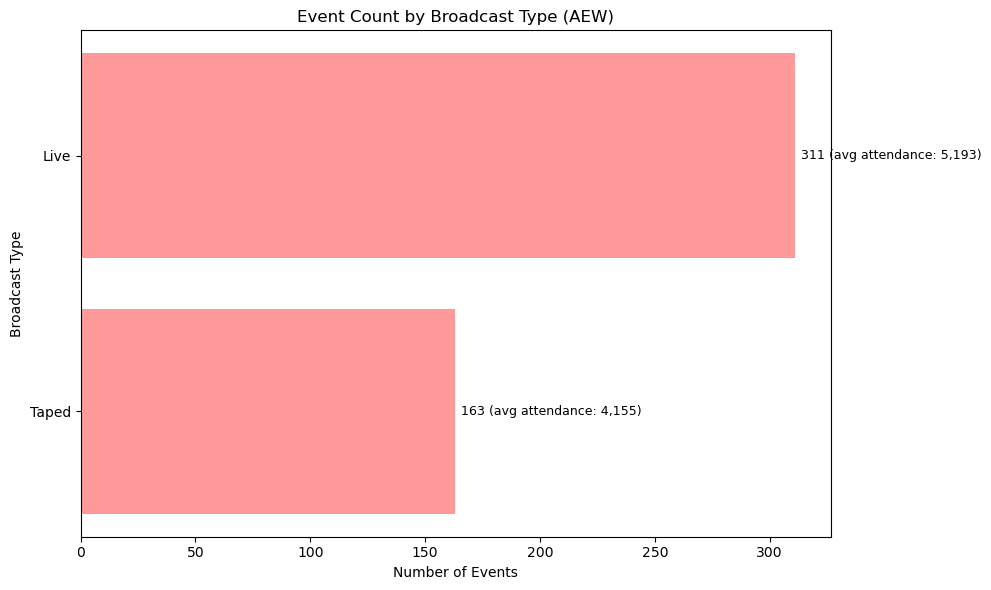

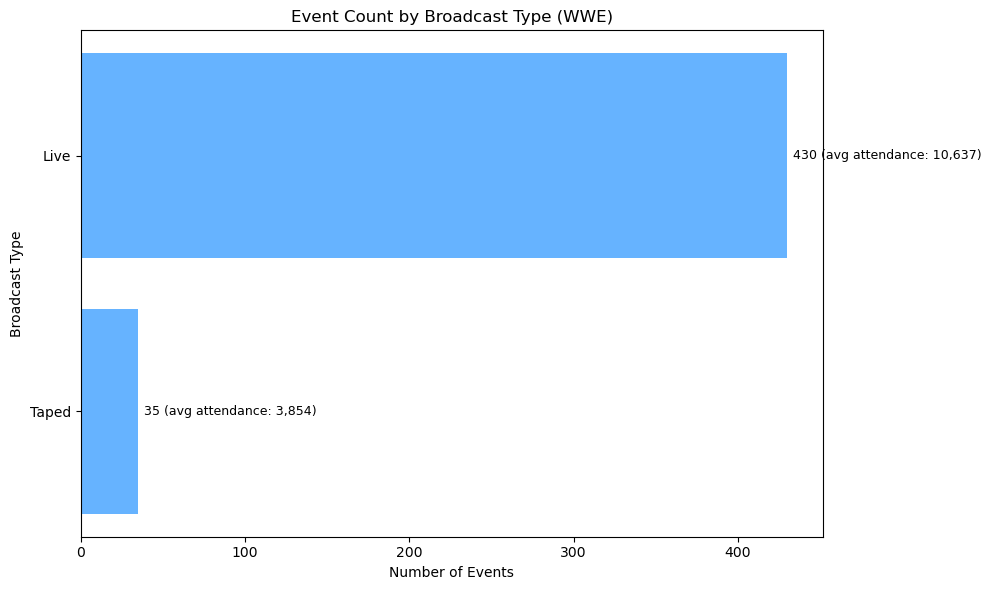

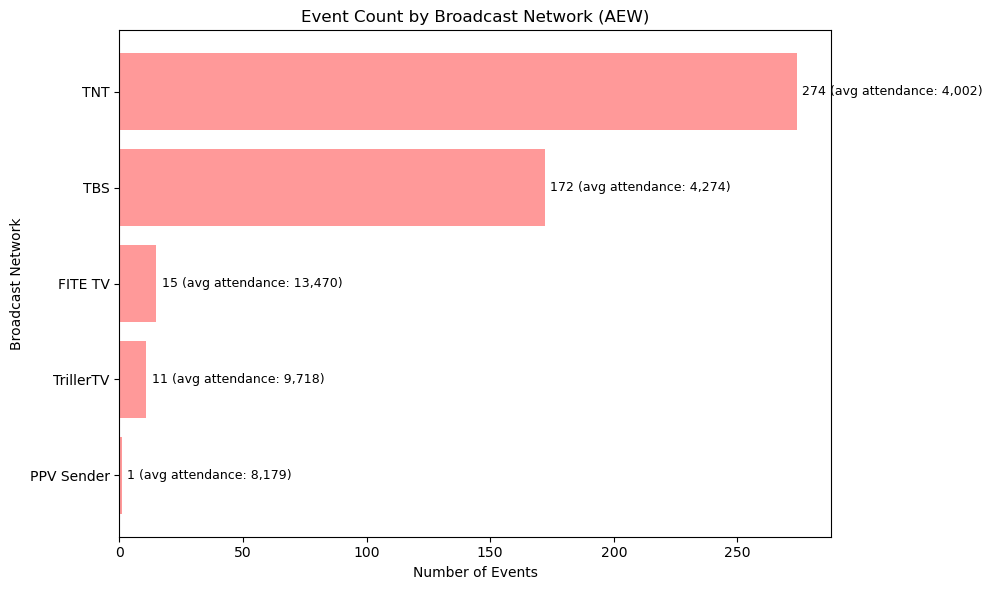

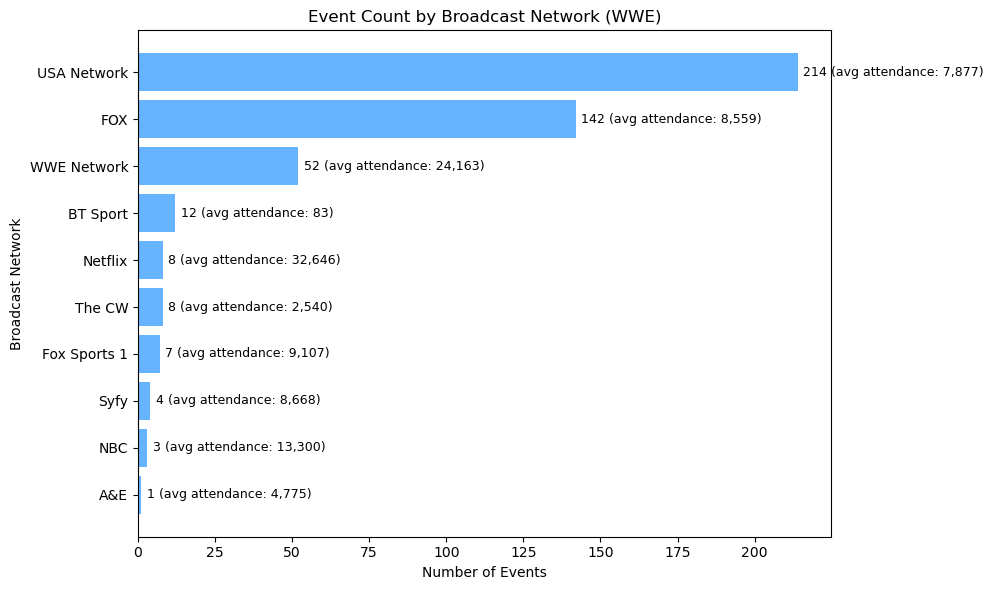

In [257]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

def plot_event_count_by_broadcast_type(promo, color, filename):
    sub = df[df['promotion'] == promo].copy()
    sub = sub[sub['event_attendance'].notnull()]
    sub['event_id'] = sub['calendar_date'].astype(str) + '|' + sub['event_name']
    stats = sub.groupby('event_broadcast_type').agg(
        mean_attendance=('event_attendance', 'mean'),
        event_count=('event_id', 'nunique')
    )
    stats = stats.dropna()
    stats = stats.sort_values('event_count', ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats.index, stats['event_count'], color=color)
    labels = [f"{int(c)} (avg attendance: {int(m):,})" for c, m in zip(stats['event_count'], stats['mean_attendance'])]
    ax.bar_label(bars, labels=labels, fontsize=9, padding=4)
    ax.set_title(f'Event Count by Broadcast Type ({promo})')
    ax.set_xlabel('Number of Events')
    ax.set_ylabel('Broadcast Type')
    ax.invert_yaxis()  # Largest bar at the top
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with unique filename
    plt.show()

def plot_event_count_by_broadcast_network(promo, color, filename):
    sub = df[df['promotion'] == promo].copy()
    sub = sub[sub['event_attendance'].notnull()]
    sub['event_id'] = sub['calendar_date'].astype(str) + '|' + sub['event_name']
    stats = sub.groupby('event_broadcast_network').agg(
        mean_attendance=('event_attendance', 'mean'),
        event_count=('event_id', 'nunique')
    )
    stats = stats.dropna()
    stats = stats.sort_values('event_count', ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats.index, stats['event_count'], color=color)
    labels = [f"{int(c)} (avg attendance: {int(m):,})" for c, m in zip(stats['event_count'], stats['mean_attendance'])]
    ax.bar_label(bars, labels=labels, fontsize=9, padding=4)
    ax.set_title(f'Event Count by Broadcast Network ({promo})')
    ax.set_xlabel('Number of Events')
    ax.set_ylabel('Broadcast Network')
    ax.invert_yaxis()  # Largest bar at the top
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with unique filename
    plt.show()

# Example usage:
plot_event_count_by_broadcast_type('AEW', colors['AEW'], 'event_count_by_broadcast_type_AEW.png')
plot_event_count_by_broadcast_type('WWE', colors['WWE'], 'event_count_by_broadcast_type_WWE.png')

plot_event_count_by_broadcast_network('AEW', colors['AEW'], 'event_count_by_broadcast_network_AEW.png')
plot_event_count_by_broadcast_network('WWE', colors['WWE'], 'event_count_by_broadcast_network_WWE.png')


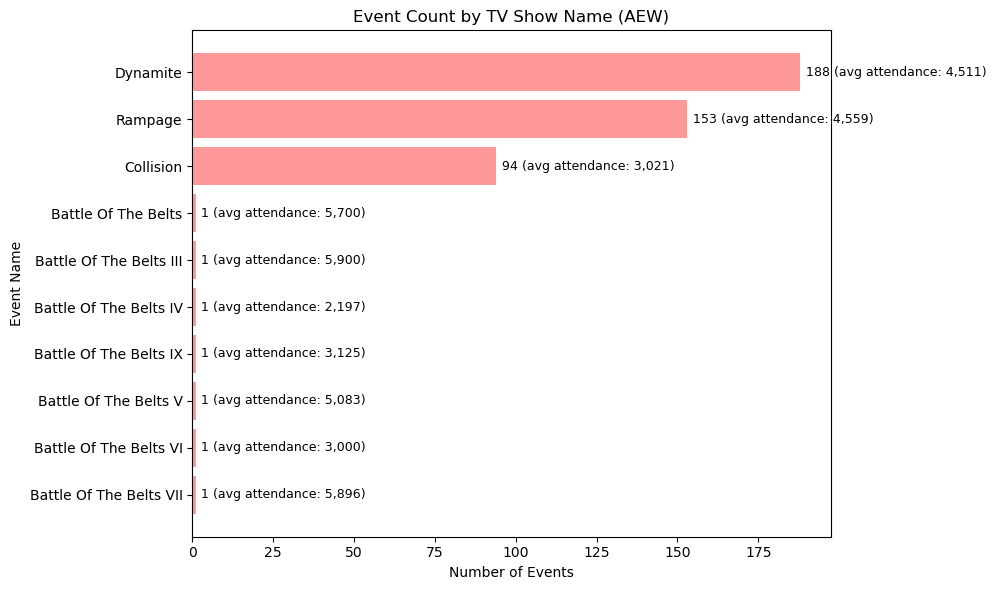

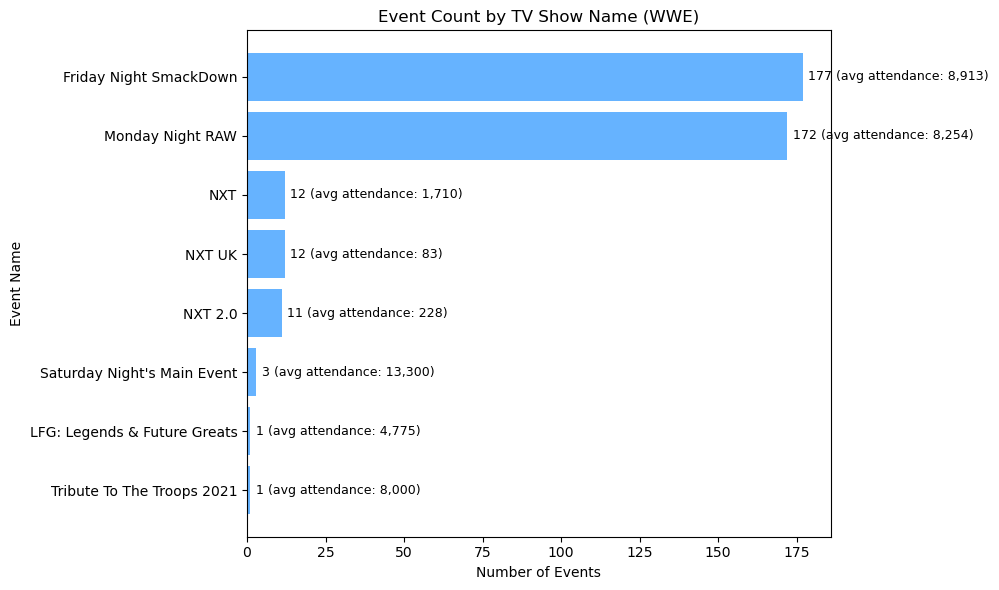

In [258]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

def plot_event_count_by_event_name_tv_show(promo, color, filename):
    sub = df[
        (df['promotion'] == promo) &
        (df['event_attendance'].notnull()) &
        (df['event_type'] == 'TV-Show')
    ].copy()
    sub['event_id'] = sub['calendar_date'].astype(str) + '|' + sub['event_name']
    stats = sub.groupby('event_name').agg(
        mean_attendance=('event_attendance', 'mean'),
        event_count=('event_id', 'nunique')
    )
    stats = stats.dropna()
    stats = stats.sort_values('event_count', ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats.index, stats['event_count'], color=color)
    labels = [
        f"{int(c)} (avg attendance: {int(m):,})"
        for c, m in zip(stats['event_count'], stats['mean_attendance'])
    ]
    ax.bar_label(bars, labels=labels, fontsize=9, padding=4)
    ax.set_title(f'Event Count by TV Show Name ({promo})')
    ax.set_xlabel('Number of Events')
    ax.set_ylabel('Event Name')
    ax.invert_yaxis()  # Largest bar at the top
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with unique filename
    plt.show()

# Example usage:
plot_event_count_by_event_name_tv_show('AEW', colors['AEW'], 'event_count_by_tv_show_AEW.png')
plot_event_count_by_event_name_tv_show('WWE', colors['WWE'], 'event_count_by_tv_show_WWE.png')


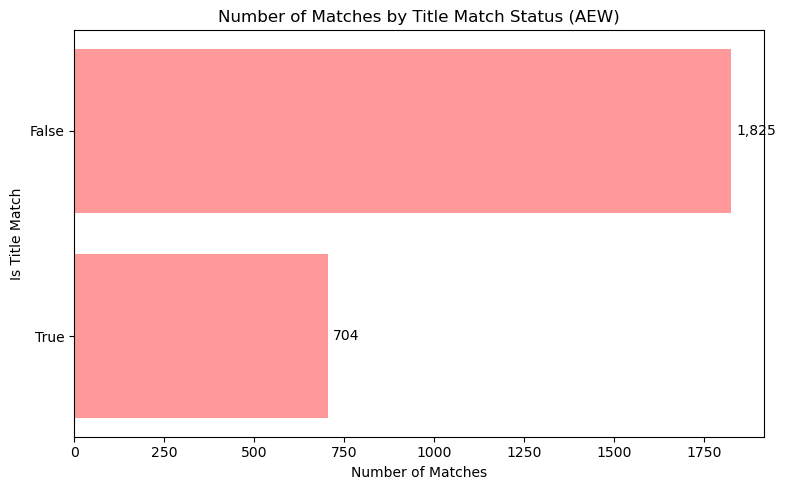

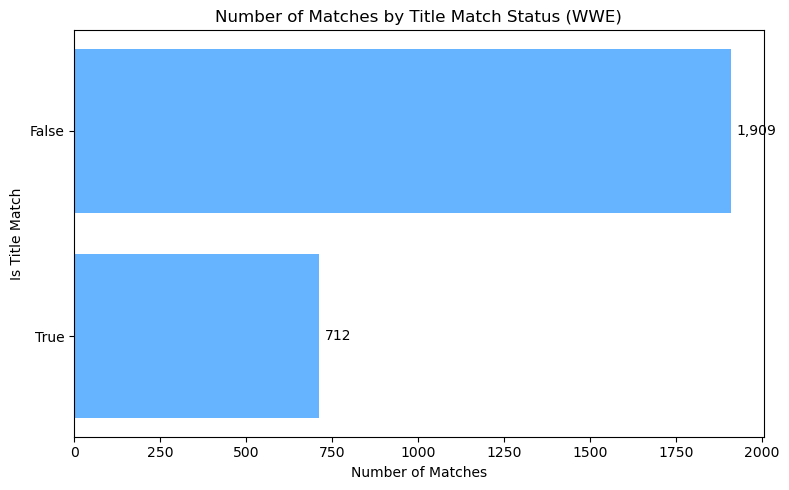

In [265]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

def plot_match_count_by_title_match(promo, color, filename):
    # Filter for the promotion and non-null attendance (optional)
    sub = df[(df['promotion'] == promo) & (df['event_attendance'].notnull())].copy()
    # Group by is_title_match and count number of matches (each row is a match)
    stats = sub.groupby('is_title_match').size().reset_index(name='match_count')
    # Sort high to low
    stats = stats.sort_values('match_count', ascending=False)
    # Convert is_title_match to string for labeling (if it is boolean or int)
    stats['is_title_match'] = stats['is_title_match'].astype(str)
    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.barh(stats['is_title_match'], stats['match_count'], color=color)
    ax.bar_label(bars, labels=[f"{c:,}" for c in stats['match_count']], fontsize=10, padding=4)
    ax.set_title(f'Number of Matches by Title Match Status ({promo})')
    ax.set_xlabel('Number of Matches')
    ax.set_ylabel('Is Title Match')
    ax.invert_yaxis()  # Largest bar at the top
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_match_count_by_title_match('AEW', colors['AEW'], 'match_count_by_title_match_AEW.png')
plot_match_count_by_title_match('WWE', colors['WWE'], 'match_count_by_title_match_WWE.png')


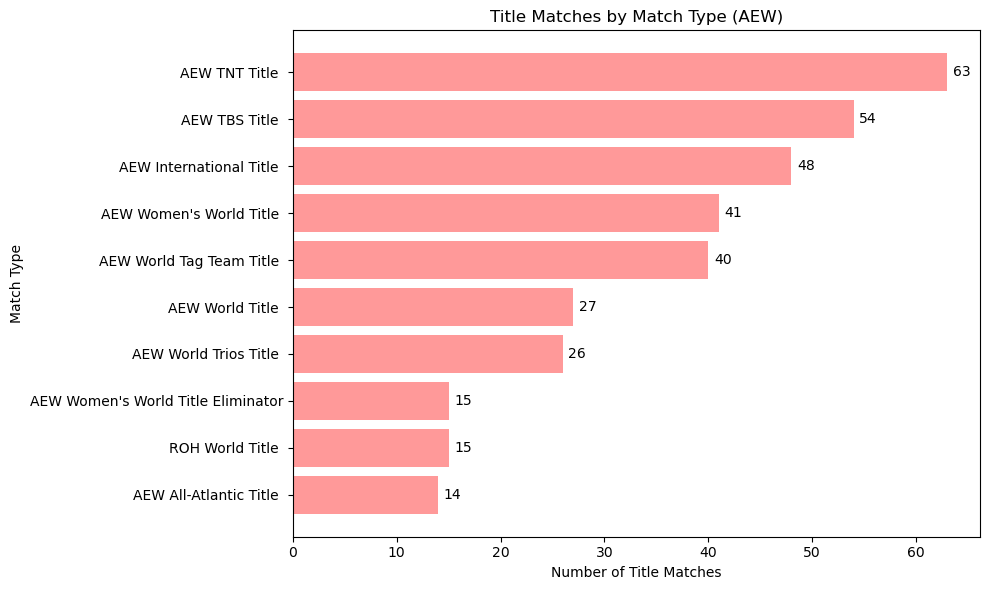

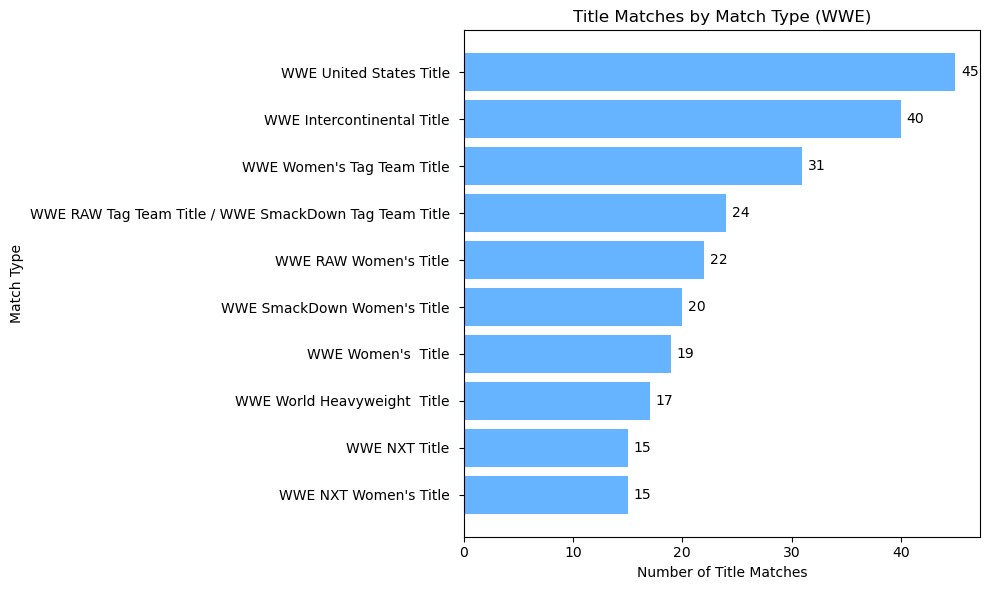

In [269]:
import pandas as pd
import matplotlib.pyplot as plt

colors = {'AEW': '#ff9999', 'WWE': '#66b3ff'}

df = pd.read_csv('report_pro_wrestling_events.csv', parse_dates=['calendar_date'])

def plot_title_match_count_by_match_type(promo, color, filename):
    # Filter for the promotion and title matches only
    sub = df[(df['promotion'] == promo) & (df['is_title_match'] == True) & (df['event_attendance'].notnull())].copy()
    # Group by match_type and count number of matches (each row is a match)
    stats = sub.groupby('match_type').size().reset_index(name='match_count')
    # Sort high to low and take top 10 (optional)
    stats = stats.sort_values('match_count', ascending=False).head(10)
    # For better visual order, reverse for barh
    stats = stats.iloc[::-1]
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(stats['match_type'], stats['match_count'], color=color)
    ax.bar_label(bars, labels=[f"{c:,}" for c in stats['match_count']], fontsize=10, padding=4)
    ax.set_title(f'Title Matches by Match Type ({promo})')
    ax.set_xlabel('Number of Title Matches')
    ax.set_ylabel('Match Type')
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_title_match_count_by_match_type('AEW', colors['AEW'], 'title_match_count_by_match_type_AEW.png')
plot_title_match_count_by_match_type('WWE', colors['WWE'], 'title_match_count_by_match_type_WWE.png')


In [ ]:
calendar_date
promotion
event_name
event_type
event_show_name
event_show_number
event_broadcast_type
event_broadcast_network
event_arena_name
event_city
event_state
event_country
match_type
is_match_stipulation
is_title_match
match_winner
match_loser
match_ended_by
match_time_limit
match_title_change
match_duration_seconds
event_attendance